<a href="https://colab.research.google.com/github/ras8wb/QuantCog-1/blob/2020_Spring/FlankerTask_WFTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#Option 3: Flanker Analysis
### Install and import what is necessary (created in Google Colab)


In [66]:

# to install RunDEMC
!pip install git+https://github.com/compmem/RunDEMC.git
# to retrieve the data
!wget https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/flanker_s1.csv
# to retrieve the wfpt model
!wget https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/wfpt.py
# to install more libraries
!pip install arviz

# load matplotlib inline mode
%matplotlib inline

# import some useful libraries
import numpy as np                # numerical analysis linear algebra
import pandas as pd               # efficient tables
import matplotlib.pyplot as plt   # plotting
from scipy import stats
import arviz as az

from RunDEMC.io import arviz_dict

from ipywidgets import interact, fixed

from RunDEMC.density import kdensity
from RunDEMC import Model, Param, dists, calc_bpic, joint_plot

from wfpt import wfpt_like, wfpt_gen


  Cloning https://github.com/compmem/RunDEMC.git to /tmp/pip-req-build-k_326e_x
  Running command git clone -q https://github.com/compmem/RunDEMC.git /tmp/pip-req-build-k_326e_x
  Created wheel for RunDEMC: filename=RunDEMC-0.1.0-cp36-none-any.whl size=44169 sha256=54b3a349029c5704c34fcba6097d9758e5ce73c0a570bdb0ca5f0b1d1cf5f026
  Stored in directory: /tmp/pip-ephem-wheel-cache-op2avgvd/wheels/9a/ad/dc/920664ad1ed11bb374c494d9a5eafc90eb77872494a7ed4feb
Successfully built RunDEMC
--2020-05-09 02:20:49--  https://raw.githubusercontent.com/compmem/QuantCog/2020_Spring/notebooks/flanker_s1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6355 (6.2K) [text/plain]
Saving to: ‘flanker_s1.csv.4’

flanker_s1.csv.4    100%[===================>]   6.21K  --.-KB/s    in 0

## Load in and visualize data

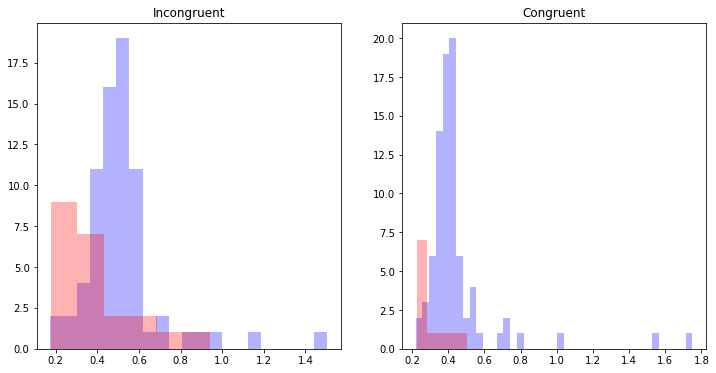

In [67]:
# load in the data
dat = pd.read_csv('flanker_s1.csv', index_col=0)
dat.head()

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.hist(dat.loc[(dat.cond=='-')&(dat.correct==True), 'rt'], 
         bins='auto', color='b', alpha=.3);
plt.hist(dat.loc[(dat.cond=='-')&(dat.correct==False), 'rt'], 
         bins='auto', color='r', alpha=.3);
plt.title('Incongruent')

plt.subplot(1,2,2)
plt.hist(dat.loc[(dat.cond=='+')&(dat.correct==True), 'rt'], 
         bins='auto', color='b', alpha=.3);
plt.hist(dat.loc[(dat.cond=='+')&(dat.correct==False), 'rt'], 
         bins='auto', color='r', alpha=.3);
plt.title('Congruent');

## Set up WFPT model and be able to play with parameters to get an idea of how they are interacting and relate to the data set

In [68]:
# set up the sim
nsims = 5000
cond='-'

# normed histogram
def dhist(dat, nvals, alpha=.3, color='b'):
    p,b = np.histogram(dat, bins='auto', density=True)
    w = b[1]-b[0]
    p *= float(len(dat))/nvals
    return plt.bar(b[1:]-w, p, width=w, alpha=.3, color=color)

# normed pdf
xvals = np.linspace(0.0,2.0,1000)

# put it all together

@interact(cond=['-', '+'],
          v_mean=(-5,5.0,0.05),
          v_std=(0.0,5.0,0.05),
          a=(0.0,5.0,.05),
          w_mode=(0.0,1.0,.05),
          w_std=(0.0,1.0,.02),
          t0=(0.0,1.0,.02),
          S=fixed(1.0),
          nsamp=fixed(2000),
          err=fixed(.0001)
          )

def run_wfpt(cond, v_mean=1.75, a=1.5, w_mode=.5, w_std=0.0,
             v_std=0.0, t0=0.0, nsamp=5000, err=.0001):

    ndat = (dat['cond']==cond).sum()
    # plot the hist of the data, followed by the model PDF line
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==True)]['rt']), ndat, color='b')
    likes = wfpt_like(np.ones(len(xvals))*2, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='b', lw=2.)
    
    dhist(np.array(dat[(dat['cond']==cond)&(dat['correct']==False)]['rt']), ndat, color='r')
    likes = wfpt_like(np.ones(len(xvals))*1, xvals, v_mean, a, w_mode, w_std=w_std,
                      v_std=v_std, t0=0, nsamp=nsamp, err=err)
    plt.plot(xvals+t0, likes, color='r', lw=2.)
    #ylim(0,5.0)
    plt.xlim(0,2.0)

interactive(children=(Dropdown(description='cond', options=('-', '+'), value='-'), FloatSlider(value=1.75, des…

In [0]:
# grab the beh data of interest
choices_I = np.array(dat[(dat['cond']=='-')]['correct']+1)
rts_I = np.array(dat[(dat['cond']=='-')]['rt'])
choices_C = np.array(dat[(dat['cond']=='+')]['correct']+1)
rts_C = np.array(dat[(dat['cond']=='+')]['rt'])
min_rt = dat.rt.min()

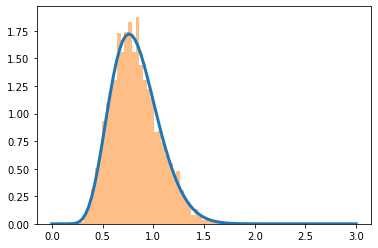

In [70]:
# explore the logit normal transformation
def logitnorm(x, mu=0.0, sigma=1.4):
    return (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-((np.log(x/(1-x))-mu)**2)/(2*sigma**2)) * (1/(x*(1-x)))

mu = -1.0
std = .4
lower = 0.0
upper = 3.0
xrng = (upper - lower)
xvals = np.linspace(0.0001, .9999, 100)
plt.plot(xvals*xrng + lower, logitnorm(xvals, mu, std)/xrng, lw=3)
plt.hist(dists.invlogit(dists.normal(mu, std).rvs(5000))*xrng + lower, bins='auto', 
         alpha=.5, density=True);

## Explore best fit when t0 and w are the only parameters kept constant between the two conditions

In [0]:
#Test freedom in drift rate and threshold

# set up the params
params = [Param(name='v_I', prior=dists.normal(0., 2.)),
          Param(name='v_C', prior=dists.normal(0., 2.)),
          Param(name='w', prior=dists.normal(0, 1.4), transform=dists.invlogit),
          Param(name='a_I', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='a_C', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
   
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first Incongruent
        likes_I = wfpt_like(choices_I, rts_I, 
                            v_mean=p['v_I'], v_std=0.0, a=p['a_I'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        likes[i] += np.log(likes_I).sum()
        if likes[i] == -np.inf:
            continue
            
        # then Congruent
        likes_C = wfpt_like(choices_C, rts_C, 
                            v_mean=p['v_C'], v_std=0.0, a=p['a_C'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        likes[i] += np.log(likes_C).sum()

    return likes
        
# make the model
m = Model('all', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          #like_args=(param_names,),
          #purify_every=5,
          verbose=True)

In [72]:

# do some burnin
times = m.sample(100, burnin=True)
# sample from the posterior
times = m.sample(500, burnin=False)

Initializing: 60(60) 2(2) Iterations (100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Iterations (500): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 1

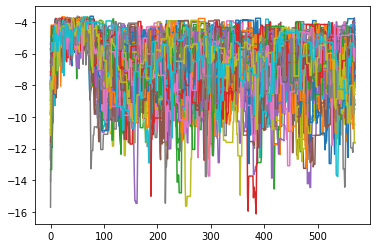

In [73]:
plt.plot(m.weights[30:]);

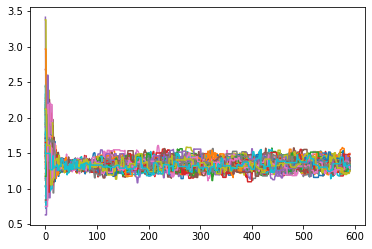

In [74]:
plt.plot(m.particles[10:, :, 3]);

In [75]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -3.7450357805558507
"v_I": 1.649641,
"v_C": 2.705587,
"w": 0.317819,
"a_I": 1.310156,
"a_C": 1.411532,
"t0": 0.139236,


# Explore best fit when w, a, and t0 are kept constant between conditions (v only free)

In [0]:

# Test holding threshold

# set up the params
params = [Param(name='v_I', prior=dists.normal(0., 2.)),
          Param(name='v_C', prior=dists.normal(0., 2.)),
          Param(name='w', prior=dists.normal(0, 1.4), transform=dists.invlogit),
          Param(name='a', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          #Param(name='a_C', prior=dists.trunc_normal(2.0, 2.0, 0., 5.0)),
          Param(name='t0', prior=dists.normal(0, 1.4), 
                transform=lambda x: dists.invlogit(x)*min_rt)]
   
param_names = [p.name for p in params]

# define the likelihood function
def like_fun(pop, *args):
    likes = np.zeros(len(pop))
    for i,p in enumerate(pop):
        # first Incongruent
        likes_I = wfpt_like(choices_I, rts_I, 
                            v_mean=p['v_I'], v_std=0.0, a=p['a'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        likes[i] += np.log(likes_I).sum()
        if likes[i] == -np.inf:
            continue
            
        # then Congruent
        likes_C = wfpt_like(choices_C, rts_C, 
                            v_mean=p['v_C'], v_std=0.0, a=p['a'], 
                            w_mode=p['w'], t0=p['t0'], w_std=0.0, 
                            nsamp=1000)
        likes[i] += np.log(likes_C).sum()

    return likes
        
# make the model
m = Model('all', params=params,
          like_fun=like_fun,
          pop_parallel=True,
          #like_args=(param_names,),
          #purify_every=5,
          verbose=True)

In [77]:

# do some burnin
times = m.sample(100, burnin=True)
# sample from the posterior
times = m.sample(500, burnin=False)

Initializing: 50(50) 3(3) Iterations (100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 
Iterations (500): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 1

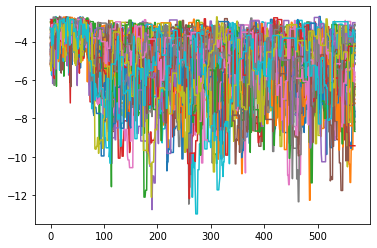

In [78]:
plt.plot(m.weights[30:]);

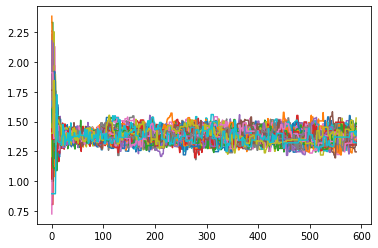

In [79]:
plt.plot(m.particles[10:, :, 3]);

In [80]:
print("Best fitting params:")
burnin=200
best_ind = m.weights[burnin:].argmax()
print("Weight:", m.weights[burnin:].ravel()[best_ind])
indiv = [m.particles[burnin:,:,i].ravel()[best_ind] 
         for i in range(m.particles.shape[-1])]
pp = {}
for p,v in zip(m.param_names,indiv):
    pp[p] = v
    print('"%s": %f,'%(p,v))

Best fitting params:
Weight: -2.696850093183606
"v_I": 1.763566,
"v_C": 2.670295,
"w": 0.310986,
"a": 1.372538,
"t0": 0.139351,


##Visualize model fit

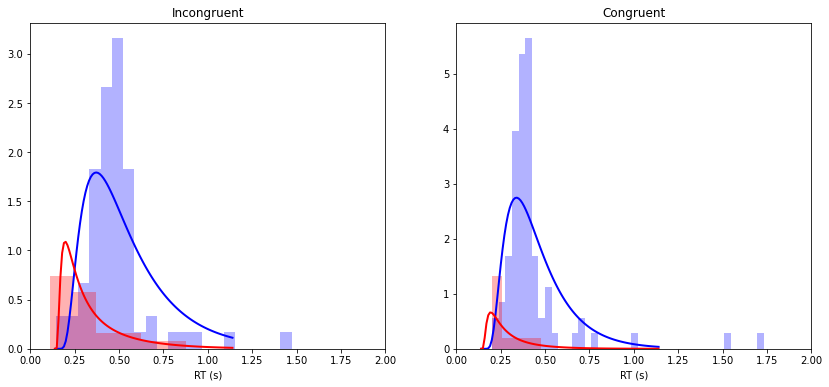

In [81]:
# set up new figure
plt.figure(figsize=(14,6))

# try different params!
plt.subplot(1,2,1)
cond='-'
run_wfpt(cond, v_mean=pp['v_I'], a=pp['a'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title('Incongruent')

plt.subplot(1,2,2)
cond='+'
run_wfpt(cond, v_mean=pp['v_C'], a=pp['a'], w_mode=pp['w'], t0=pp['t0'])
plt.xlabel('RT (s)')
plt.xlim(0,2.0)
plt.title('Congruent');

Above, the Wiener First Passage of Time Model has been fit to incongruent and congruent trials of the Flanker Task. The parameters that were used were t0, the time evidence first started to be accumulated; v, the drift rate; w, the bias; and a, the threshold. Various trials were run to determine which models should be kept free between the two conditions, with the results shown above for two of these. The parameters that should be kept constant between the two conditions were t0, w, and a, while v should be allowed to vary. The other option was to vary the drift rate and threshold between the two conditions, but this did not fit the data as well as shown by the weights generated above.

##Posterior examination and exploration

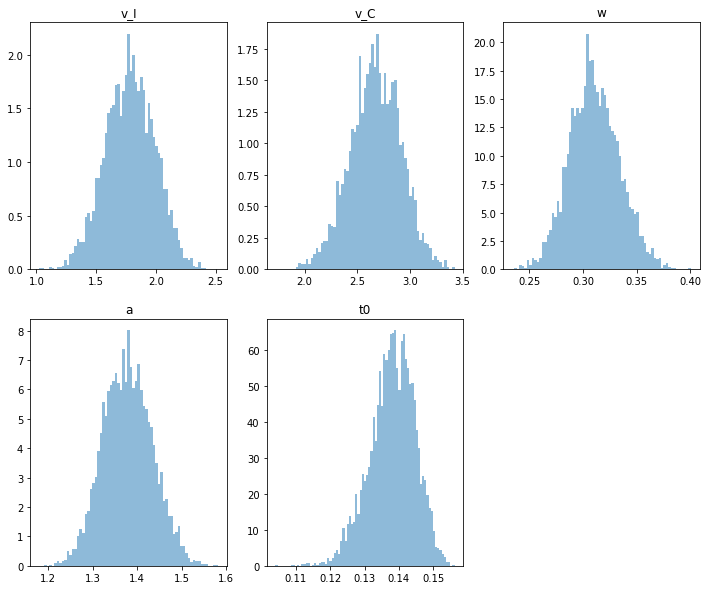

In [82]:
plt.figure(figsize=(12,10))
burnin=200
for i in range(len(params)):
    plt.subplot(2,3,i+1)
    plt.hist(m.particles[burnin:, :, i].flatten(), bins='auto', alpha=.5, density=True);
    plt.title(m.param_names[i])

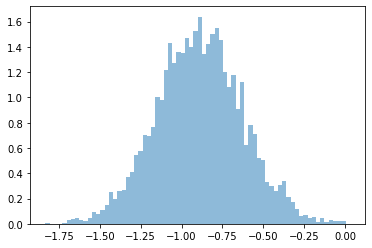

In [83]:
plt.hist(m.particles[burnin:, :, 0].flatten() - m.particles[burnin:, :, 1].flatten(),
         bins='auto', alpha=.5, density=True);

/usr/local/lib/python3.6/dist-packages/RunDEMC/density.py:105: RuntimeWarning: invalid value encountered in sqrt
  std_devs = np.diag(np.sqrt(cov))


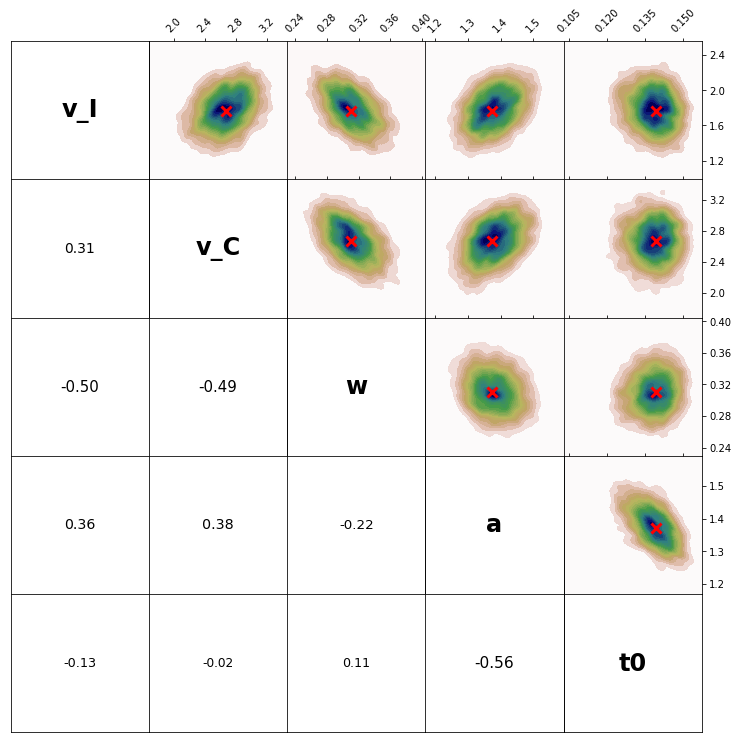

In [84]:
plt.figure(figsize=(12,12))

burnin = 200
joint_plot(m.particles, m.weights, burnin=burnin, 
           names=m.param_display_names, rot=45);

As can be seen in the above graph, t0 and a are highly negatively correlated as well as the bias and the two drift rates respectively. 

In [85]:
# save out model to an ArviZ Inference Dataset
daz_t = az.from_dict(**arviz_dict(m, burnin=200))
daz_t.posterior

<xarray.Dataset>
Dimensions:  (chain: 50, draw: 401)
Coordinates:
  * chain    (chain) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 393 394 395 396 397 398 399 400
Data variables:
    v_I      (chain, draw) float64 1.827 1.673 1.673 1.673 ... 1.837 2.059 1.634
    v_C      (chain, draw) float64 2.474 2.738 2.738 2.738 ... 2.868 2.85 2.595
    w        (chain, draw) float64 0.3257 0.3441 0.3441 ... 0.3021 0.2936 0.3453
    a        (chain, draw) float64 1.263 1.37 1.37 1.37 ... 1.393 1.426 1.386
    t0       (chain, draw) float64 0.1501 0.1402 0.1402 ... 0.1336 0.1345 0.137
Attributes:
    created_at:     2020-05-09T02:39:05.498656
    arviz_version:  0.7.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe07ed052b0>,
      dtype=object)

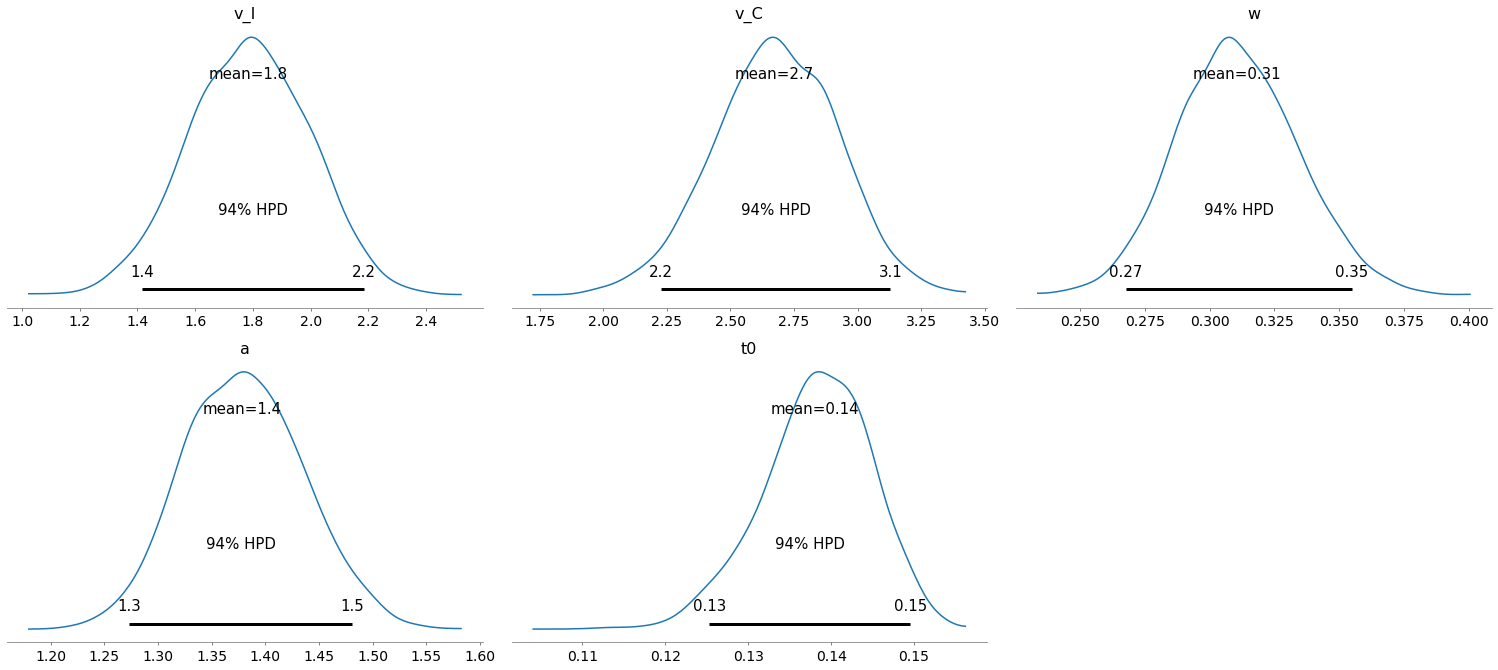

In [86]:
az.plot_posterior(daz_t, var_names= ['v_I','v_C','w','a','t0'])

 Graphs showing the best fit to the data can be seen above, as well as the posteriors for all of the parameters. These posteriors do make sense and the range of values given for each parameter are relatively narrow. The values obtained for best fitting parameters are within the ranges for the posterior given.